## PreTraining on Unlabeled Data the GPT Model

In [72]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [73]:
from tokenizers import Tokenizer
from tokenizers.models import BPE

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

from tokenizers.trainers import BpeTrainer

trainer = BpeTrainer(
    special_tokens=["[UNK]", "[PAD]", "[MASK]", "<|endoftext|>"]
)

In [74]:
from tokenizers.pre_tokenizers import Whitespace

tokenizer.pre_tokenizer = Whitespace()

In [75]:
tokenizer.train(["/content/roman_02.txt"], trainer)

In [76]:
tokenizer.save("tokenizer_roman_02.json")

In [77]:
vocab_size = tokenizer.get_vocab_size()

In [78]:
class LayerNormalization(torch.nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # bessel correction n instead of (n -1 )
        norm_x = (x - mean) / torch.sqrt(var + self.eps) # prevent divide by zero
        return norm_x * self.scale + self.shift # two learnable parameters model learns during training

In [79]:
class GeLU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [80]:
class FeedForward(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["embedding_size"], 4 * cfg["embedding_size"]),
            GeLU(),
            nn.Linear(4 * cfg["embedding_size"], cfg["embedding_size"])
        )

    def forward(self, x):
        return self.layers(x)

In [81]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_Query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_Key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_Value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.size() # batch, num_tokens, dimension

        keys = self.W_Key(x)
        queries = self.W_Query(x)
        values = self.W_Value(x)
        # We change last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim) to split the d_out in num_heads part
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # transpose (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attention_scores = queries @ keys.transpose(-2, -1) # we transpose the last two dimension as the first two will be broadcased

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attention_scores.masked_fill_(mask_bool, float("-inf"))

        attention_weights = torch.nn.functional.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)

        attention_weights = self.dropout(attention_weights)

        context_vectors = (attention_weights @ values).transpose(1, 2) # (b, num_heads, num_tokens, head_dim) -> (b, num_tokens, num_heads, head_dim)

        context_vectors = context_vectors.contiguous().view(b, num_tokens, self.d_out)
        context_vectors = self.out_proj(context_vectors)

        return context_vectors

In [82]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["embedding_size"],
            d_out=cfg["embedding_size"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNormalization(cfg["embedding_size"])
        self.norm2 = LayerNormalization(cfg["embedding_size"])
        self.drop_skip = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        skip = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_skip(x)
        x = x + skip

        skip = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_skip(x)
        x = x + skip

        return x

In [83]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["embedding_size"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["embedding_size"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNormalization(cfg["embedding_size"])
        self.out_head = nn.Linear(cfg["embedding_size"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

In [84]:
GPT_CONFIG_124M = {
    "vocab_size": tokenizer.get_vocab_size(),
    "context_length": 512,
    "embedding_size": 512,
    "n_heads": 8,
    "n_layers": 4,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [85]:
model = GPTModel(GPT_CONFIG_124M)

## Utils Function

In [86]:
def generate_text_sample(model, idx, max_new_tokens, context_size):
    """
    Generates a new token in autoregressive manner given a seed token

    Args:
       - model: The GPT Model
       - idx: The seed text token ids
       - max_new_tokens: The maximum number of tokens we want to generate
       - context_size: The number of tokens to consider at one time during inference
    """
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # get all batch, and only the last context_size tokens
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :] # get the logits for only the last token which is what we used to predict the next token
        probs = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)
        idx = torch.cat([idx, idx_next], dim=1)

    return idx

In [87]:
# def text_to_token_ids(text, tokenizer):
#   encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
#   encoded_tensor = torch.tensor(encoded).unsqueeze(0)
#   return encoded_tensor

# def token_ids_to_text(token_ids, tokenizer):
#   flat = token_ids.squeeze(0)
#   return tokenizer.decode(flat.tolist())

In [88]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text).ids
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

In [89]:
start_context = "Nepal"

In [90]:
token_ids = generate_text_sample(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

e pal sthaniyavasilai kalpanika kshamatama yatharthama tithima dekh sambandhana talabako sukhi aphusa


## Model Generalization Error

In [91]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [92]:
with torch.no_grad():
  logits = model(inputs)


probabilities = torch.softmax(logits, dim=-1)
print(probabilities.shape)

torch.Size([2, 3, 30000])


In [93]:
token_ids = torch.argmax(probabilities, dim=-1, keepdim=True)
print(f"Token Ids: {token_ids}")

Token Ids: tensor([[[ 6510],
         [24956],
         [27107]],

        [[21884],
         [13735],
         [19380]]])


In [94]:
print(f"Targets of 1st batch: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs of 1st batch: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets of 1st batch: rgha chaitra ‘
Outputs of 1st batch: parikshama ashramama bayometrika


In [95]:
text_idx = 0
target_probs_1 = probabilities[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probs_1)

Text 1: tensor([4.6326e-05, 1.4399e-05, 2.5364e-05])


In [96]:
text_idx = 1
target_probas_2 = probabilities[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 2: tensor([2.2811e-05, 6.6859e-05, 6.7203e-05])


### Log Likelihood

The goal of the training is to maximize these probabilities and get as close to 1.

In [97]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probs_1, target_probas_2)))
print(log_probas)

tensor([ -9.9798, -11.1484, -10.5822, -10.6883,  -9.6129,  -9.6078])


In [98]:
torch.log(torch.tensor(0.01))

tensor(-4.6052)

In [99]:
average_log_probabilities = torch.mean(log_probas)
print(average_log_probabilities) # calculation of average log likelihood

tensor(-10.2699)


In [100]:
# negative log likelihood
negative_log_likelihood = -1 * average_log_probabilities
print(negative_log_likelihood)

tensor(10.2699)


The common practice is to minimize the negative log likelihood as close to 0

In [101]:
print(f"Logits shape: {logits.shape}")
print(f"Targets shape: {targets.shape}")

Logits shape: torch.Size([2, 3, 30000])
Targets shape: torch.Size([2, 3])


In [102]:
tensor_a = torch.tensor([[[1,2,3],
                          [4,5,6]],
                         [[9,8,9],
                         [2,1,4]]])
tensor_b = torch.tensor([[900,800],
                         [200,400]])

tensor_a.shape, tensor_b.shape

(torch.Size([2, 2, 3]), torch.Size([2, 2]))

In [103]:
tensor_a_flat = tensor_a.flatten(start_dim=0, end_dim=1)
tensor_b_flat = tensor_b.flatten(0, 1)

tensor_a, tensor_a_flat, tensor_b, tensor_b_flat

(tensor([[[1, 2, 3],
          [4, 5, 6]],
 
         [[9, 8, 9],
          [2, 1, 4]]]),
 tensor([[1, 2, 3],
         [4, 5, 6],
         [9, 8, 9],
         [2, 1, 4]]),
 tensor([[900, 800],
         [200, 400]]),
 tensor([900, 800, 200, 400]))

In [104]:
logits_flat = logits.flatten(start_dim=0, end_dim=1)
targets_flat = targets.flatten()
print(f"Flat logits shape: {logits_flat.shape}")
print(f"Flat targets shape: {targets_flat.shape}")

Flat logits shape: torch.Size([6, 30000])
Flat targets shape: torch.Size([6])


In [105]:
targets, targets_flat

(tensor([[ 3626,  6100,   345],
         [ 1107,   588, 11311]]),
 tensor([ 3626,  6100,   345,  1107,   588, 11311]))

In [106]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.2699)


Here `PyTorch` will handle the conversion of logits to softmax and then calculate the negative log likelihood for use so we just need to send the probabilities of predicted tokens i.e [6, vocab_size] and the actual target ids [6].

### Perplexity
It is a measure often used alongside cross entropy loss to evaluate the performance of models in tasks like language modeling.

It can provide a more interpretable way to understand the uncertainity of the model in predicting the next token in a sequence.

In [107]:
perplexity = torch.exp(loss)
perplexity

tensor(28850.6270)

## Calculation of validation and Traning error

In [108]:
with open("./roman_02.txt", "r", encoding="utf-8") as f:
  text = f.read()

In [109]:
total_characters = len(text)
total_tokens = len(tokenizer.encode(text))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 37598550
Tokens: 6271371


In [110]:
train_ratio = 0.90
split_idx = int(total_characters * train_ratio)
train_data = text[:split_idx]
val_data = text[split_idx:]

In [111]:
from torch.utils.data import Dataset, DataLoader

class DatasetV1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        """create a dataset from the txt"""
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(text).ids

        for i in range(0, len(token_ids) - max_length, stride): # stride is for overlapping
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
            return len(self.input_ids)

    def __getitem__(self, idx):
            return self.input_ids[idx], self.target_ids[idx]

In [112]:
def create_dataloaderV1(text, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    # initializing tokenizer

    dataset = DatasetV1(text, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size, shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [113]:
torch.manual_seed(123)

train_loader = create_dataloaderV1(
    train_data,
    batch_size=32,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloaderV1(
    val_data,
    batch_size=32,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [114]:
# Sanity check
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [115]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 51

## Calculate the batch generalization error

In [116]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
  return loss

In [117]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0.
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss = total_loss + loss.item()
    else:
      break
  return total_loss / num_batches

In [120]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
  # train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)

  # print(f"Train loss: {train_loss:.3f}")
  print(f"Validation loss: {val_loss:.3f}")

Validation loss: 10.478


## Traning Model

In [121]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    # train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
  model.train()
  return val_loss

In [122]:
def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_sample(model, encoded, max_new_tokens=50, context_size=context_size)
  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " "))
  model.train()

In [125]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()

      loss = calc_loss_batch(input_batch, target_batch, model, device)

      loss.backward()

      optimizer.step()

      tokens_seen += input_batch.numel()

      global_step += 1

      if global_step % eval_freq == 0:
        val_loss = evaluate_model(
            model,
            train_loader,
            val_loader,
            device,
            eval_iter
        )
        loss_ = loss.item()
        train_losses.append(loss_)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Epoch: {epoch} (Step: {global_step:06d}): Train loss: {loss_:.3f}, Val loss: {val_loss:.3f}")

    generate_and_print_sample(
        model, tokenizer, device, start_context
    )

  return train_losses, val_losses, track_tokens_seen


In [126]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.1)

num_epochs = 15

train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="hami sabai",
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch: 0 (Step: 000000): Train loss: 10.471, Val loss: 10.388
Epoch: 0 (Step: 000005): Train loss: 10.046, Val loss: 9.923
Epoch: 0 (Step: 000010): Train loss: 9.573, Val loss: 9.523
Epoch: 0 (Step: 000015): Train loss: 9.344, Val loss: 9.212
Epoch: 0 (Step: 000020): Train loss: 9.027, Val loss: 8.990
Epoch: 0 (Step: 000025): Train loss: 8.842, Val loss: 8.784
Epoch: 0 (Step: 000030): Train loss: 8.642, Val loss: 8.622
Epoch: 0 (Step: 000035): Train loss: 8.511, Val loss: 8.477
Epoch: 0 (Step: 000040): Train loss: 8.385, Val loss: 8.361
Epoch: 0 (Step: 000045): Train loss: 8.214, Val loss: 8.265
Epoch: 0 (Step: 000050): Train loss: 8.186, Val loss: 8.192
Epoch: 0 (Step: 000055): Train loss: 8.165, Val loss: 8.130
Epoch: 0 (Step: 000060): Train loss: 8.137, Val loss: 8.081
Epoch: 0 (Step: 000065): Train loss: 8.017, Val loss: 8.045
Epoch: 0 (Step: 000070): Train loss: 7.999, Val loss: 8.019
Epoch: 0 (Step: 000075): Train loss: 8.012, Val loss: 7.999
Epoch: 0 (Step: 000080): Train loss: 

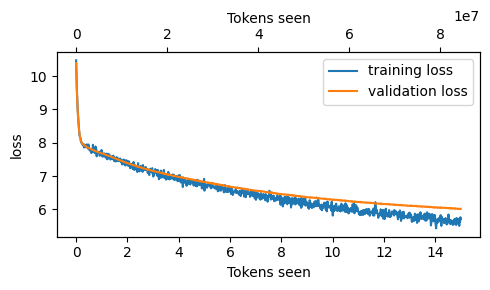

In [127]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(5, 3))

  ax1.plot(epochs_seen, train_losses, label="training loss")
  ax1.plot(epochs_seen, val_losses, label="validation loss")
  ax1.set_xlabel("Tokens seen")
  ax1.set_ylabel("loss")
  ax1.legend()
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses, alpha=0)
  ax2.set_xlabel("Tokens seen")

  fig.tight_layout()
  plt.savefig("loss-plot.pdf")
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


## Decoding strategies to control randomness

In [128]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(30000, 512)
  (pos_emb): Embedding(512, 512)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_Query): Linear(in_features=512, out_features=512, bias=False)
        (W_Key): Linear(in_features=512, out_features=512, bias=False)
        (W_Value): Linear(in_features=512, out_features=512, bias=False)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GeLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (drop_skip): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_Query): Line

In [129]:
token_ids = generate_text_sample(model, text_to_token_ids("Every effort moves you", tokenizer), 100, GPT_CONFIG_124M["context_length"])
print(token_ids_to_text(token_ids, tokenizer))

very e f for t mo ves you can in pharme e mail ) le gareko cha . kathamadaum . nepala rashtra baimkale ru . 1 arba rupaiya . n barabarako sheyara nishkasana gareko cha . baimkale ru . 1 arba rupaiya . n barabarako sheyara nishkasana gareko cha . baimkale ru . 1 arba rupaiya . n barabarako sheyara nishkasana gareko cha . baimkale ru . 1 arba rupaiya . n barabarako sheyara nishkasana gareko cha . baimkale ru . 1 arba rupaiya . n napha kamaeko cha . baimkale ru . n barabarako seyara karobara gareko cha . baimkale ru . 1 arba rupaiya . n


## Temperature Scaling

In [130]:
# def print_sampled_tokens(probas):
#   torch.manual_seed(123)
#   sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
#   sampled_ids = torch.bincount(torch.tensor(sample))

#   print(f"Count of sampled token id: {sampled_ids}")

#   for i, freq in enumerate(sampled_ids):
#     print(f"{freq} * {inverse_vocab[i]}")

# print_sampled_tokens(probas)

In [131]:
def softmax_with_temperature(logits, temperature):
  scaled_logits = logits / temperature
  return torch.softmax(scaled_logits, dim=0)

Temperature greater than 1 will result in more uniformly distributed token probabilities after applying the softmax and the Temperature smaller than 1 will result in more confident distributions after applying hte softmax.

## Top-K Sampling

## Generate Text with Control Randomness

In [132]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]

    if top_k is not None:
      top_logits, _ = torch.topk(logits, top_k)
      # get the minimum value from the logits for all batch here (only one batch)
      min_val = top_logits[:, -1]
      logits = torch.where(logits < min_val, torch.tensor(float("-inf")), logits).to(logits.device)

    if temperature > 0.0:
      logits = logits / temperature

      probs = torch.softmax(logits, dim=-1)

      idx_next = torch.multinomial(probs, num_samples=1)

    else:
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)

    if idx_next == eos_id:
      break

    idx = torch.cat((idx, idx_next), dim=1) # (batch_size, num_tokens + 1)

  return idx

In [136]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("hello", tokenizer),
    max_new_tokens=100,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=None,
    temperature=1.2
)

print("Output text: ", token_ids_to_text(token_ids, tokenizer))

Output text:  hello dai era unale mageko thiyo , jasari sathiharusa . nga pani bhanna sakchu , uni aisakeko layama thiyo , .' sarubhakta chaum . bechda antima jita pachi 11 ra jita vyavasaya garna sakdainan nishchita 2 kamsya saki . ndain . dhamala sambedanashila denta duvai tipsa sa . nga gare bamojima rojne ra yuropama jhagada maula une ani tyasapachi premale pariksha dina pachi gorkhalyanda batai gareko arko mudda dinchin . lade garna rcha . ghadi rahin . sa / pathegharako ayojanaharuko babu lagna sakenan jasta vyaktiharule 10 lakha madhye parivaralai kula prayogama lyauna sakcha bhanne sandesha tire bajetama pathyakrama hunuparcha bhanne


In [142]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("tara j bane pani auta kura chai", tokenizer),
    max_new_tokens=100,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=None,
    temperature=1.2
)

print("Output text: ", token_ids_to_text(token_ids, tokenizer))

Output text:  tara j bane pani auta kura chai biela lai harae . tatkalina samvadako lata ji chepa ~ naharu roshana ramabahadura guru ye naharule chuttairajya ta kla nagarne , suvasa yogi raja koirala , pratibha guru shanti samjhautaka hu nepaliko manyataka shraddha ul aphni se sam kau pi din di chauda sa purni yuga mandira hum riya shilalekha radhakrrishna gaya lai shahida kyamera samata ko puja garne anurodha gari jema kira svarupa paipalaina karyakrama kala bhavana vibhagaka pra janata sam palika ayojaka dahala ra devi re lalitapurako kala bi pi varama guru shu bahirieka thie vi sthapitale gai rva chanama sammelanako avasara rahema tiko vyaktitvako nidhanapachi hareka kshamata


## Loading and saving model weights in PyTorch

In [134]:
torch.save(model.state_dict(), "model.pth")

In [135]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("./model.pth", map_location=device, weights_only=True))

model.eval()

GPTModel(
  (tok_emb): Embedding(30000, 512)
  (pos_emb): Embedding(512, 512)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_Query): Linear(in_features=512, out_features=512, bias=False)
        (W_Key): Linear(in_features=512, out_features=512, bias=False)
        (W_Value): Linear(in_features=512, out_features=512, bias=False)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GeLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (drop_skip): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_Query): Line

It's common to train LLMs with adaptive optimizers like Adam or AdamW instead of regular SGD
These adaptive optimizers store additional parameters for each model weight, so it makes sense to save them as well in case we plan to continue the pretraining later: